In [ ]:
!pip install opendatasets --upgrade #to download datasets from kaggle, with less than 69gb/2

In [ ]:
import opendatasets as od
#dataset_url = 'https://www.kaggle.com/competitions/g2net-gravitational-wave-detection/data'
dataset_url = 'https://www.kaggle.com/datasets/diegogarro3/g2net-gravitational-wave-detection'
od.download(dataset_url)

Skipping, found downloaded files in "./g2net-gravitational-wave-detection" (use force=True to force download)


In [ ]:
pip install nnAudio

In [ ]:
#upload a zip and descomprimelo, very slow, only for less than 1 gb file or even less
from google.colab import files
files.upload()

KeyboardInterrupt: ignored

In [ ]:
import zipfile
import os

# Nombre del archivo ZIP
zip_file_name = "g2net-gravitational-wave-detectionS.zip"
#zip_file_name = "g2net-gravitational-wave-detection/g2net-gravitational-wave-detection.zip"

# Directorio de destino para la extracción
extraction_path = "kaggle/input/"
#extraction_path = "g2net-gravitational-wave-detection/"

# Descomprimir el archivo ZIP
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# Lista el contenido de la carpeta extraída
os.listdir(extraction_path)

In [ ]:
import pandas as pd # Panel Data
import matplotlib.pyplot as plt # Make Grafics
from matplotlib.gridspec import GridSpec # Axes os Graphics
import numpy as np #Lineal Algebra
import warnings #Ignore Warnings
from random import shuffle
import tensorflow as tf #Model and Dataset
from sklearn.model_selection import train_test_split
from scipy import signal
warnings.filterwarnings("ignore")

train_labels = pd.read_csv("/content/g2net-gravitational-wave-detection/g2net-gravitational-wave-detectionS3.5t/training_labels.csv")
sample_submission = pd.read_csv("/content/g2net-gravitational-wave-detection/g2net-gravitational-wave-detectionS3.5t/sample_submission.csv")

Reduce the amount of data to work with and train the CNN


In [ ]:
#to work with less data. The hierarchy is: 0_0_0_stringID, in general: k_j_i_stringID
#let's work with 0_0_i_stringID
#modify the id for the paths IN training_labels
#print(train_labels["id"][0])

### way 1
#get_letters = lambda text: ''.join(filter(str.isalpha, text))???????
# Apply the function to the 'Text' column
#df['Letters'] = df['Text'].apply(get_letters)

### way 2


#print(type((train_labels["id"].astype(str).str[0])[0]))
#print(train_labels["id"].astype(str).str[0]=="0") #Mask
#print(train_labelsS["id"][0][0])
#descomentar para 7gb
print(train_labels["id"])
train_labelsS=train_labels[(train_labels["id"].astype(str).str[0]=="0") ]#| (train_labels["id"].astype(str).str[0]=="3") ]
sample_submission=sample_submission[(sample_submission["id"].astype(str).str[0]=="0") ]#| (sample_submission["id"].astype(str).str[0]=="0")]
print(train_labelsS["id"])

#descomentar para 223mb
#train_labelsS=train_labelsS[train_labelsS["id"].str[1]=="0"]
#sample_submission=sample_submission[sample_submission["id"].str[1]=="0"]
#rain_labelsS=train_labelsS[(train_labelsS["id"].str[1]=="0") | (train_labelsS["id"].str[1]=="1") ] #for 0_0_i and 0_1_i or even 0_j_i
#print(train_labelsS["id"])
train_labels=train_labelsS #to work with the same code

0         00000e74ad
1         00001f4945
2         0000661522
3         00007a006a
4         0000a38978
             ...    
559995    ffff9a5645
559996    ffffab0c27
559997    ffffcf161a
559998    ffffd2c403
559999    fffff2180b
Name: id, Length: 560000, dtype: object
0        00000e74ad
1        00001f4945
2        0000661522
3        00007a006a
4        0000a38978
            ...    
35155    0fff6111fc
35156    0fff7d6278
35157    0fff98fddd
35158    0fffa35159
35159    0fffa7dff1
Name: id, Length: 35160, dtype: object


# Get the Path

In [ ]:
def id2path(idx, is_train = True):
    path = "/content/g2net-gravitational-wave-detection/g2net-gravitational-wave-detectionS3.5t"

    if is_train:
        path += "/train/" + idx[0] + "/" + idx[1] + "/" + idx[2] + "/" + idx + ".npy"

    else:
        path += "/test/" + idx[0] + "/" + idx[1] + "/" + idx[2] + "/" + idx + ".npy"

    return path

# Increase Dimension whit Constant Q-Transform

In [ ]:
from nnAudio.Spectrogram import CQT1992v2
import torch

def increase_dimension(idx, is_train, transform = CQT1992v2(sr = 2048, hop_length = 64, fmin = 20, fmax = 500)):
    wave = np.load(id2path(idx, is_train)) #load .npy array data
    wave = np.concatenate(wave, axis = 0) #concatenate the 3 detectors waves, 3 1d ARRAY Into 1 1d array
    bHP, aHP = signal.butter(8, (20, 500), btype='bandpass', fs=2048)# This line designs a bandpass Butterworth filter
    #It returns the numerator (bHP) and denominator (aHP) coefficients of the filter.
    window = signal.tukey(4096*3, 0.2) #createa window
    wave *= window #put the wave on the window
    wave = signal.filtfilt(bHP, aHP, wave) #apply te filter
    wave = wave / np.max(wave)#normalization
    wave = torch.from_numpy(wave).float() #convert
    image = transform(wave)
    image = np.array(image)
    image = np.transpose(image, (1, 2, 0))

    return image

CQT kernels created, time used = 0.0193 seconds


Text(0, 0.5, 'Log Frequency?')

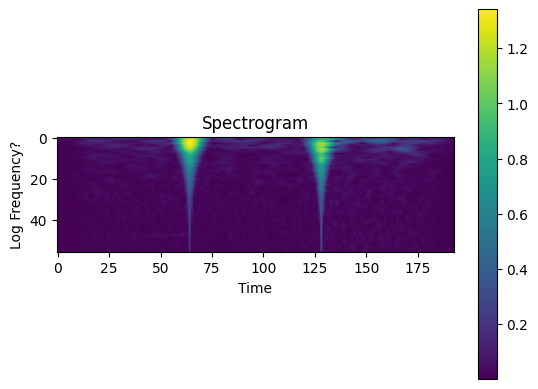

In [ ]:
#the id is in train_labels, use the id fromit to find the path of each training data
Spectrogram=increase_dimension(train_labels["id"][0], is_train = True)
# spectrogram created for the first id
#ax4 = fig.add_subplot(gs[i*2, 3])
plt.imshow(Spectrogram)
plt.colorbar()
plt.title("Spectrogram")
plt.xlabel("Time")
plt.ylabel("Log Frequency?")
#ax4.set_axis_off()

# Visualize the data

In [ ]:
#the IDs for the detected Gravitational Wave (GW) event
targets = train_labels[train_labels["target"] == 0]["id"].head()
#the IDs with no Gravitational Wave (GW) event detected
no_targets = train_labels[train_labels["target"] == 1]["id"].head()
print(targets)
print("nuumber of events with detected gravitational waves",len(train_labels[train_labels["target"] == 0]["id"]))
print("nuumber of events without detected gravitational waves",len(train_labels[train_labels["target"] == 1]["id"]))

1     00001f4945
2     0000661522
3     00007a006a
6     0000c3b9c9
10    000118b40d
Name: id, dtype: object
nuumber of events with detected gravitational waves 17706
nuumber of events without detected gravitational waves 17454


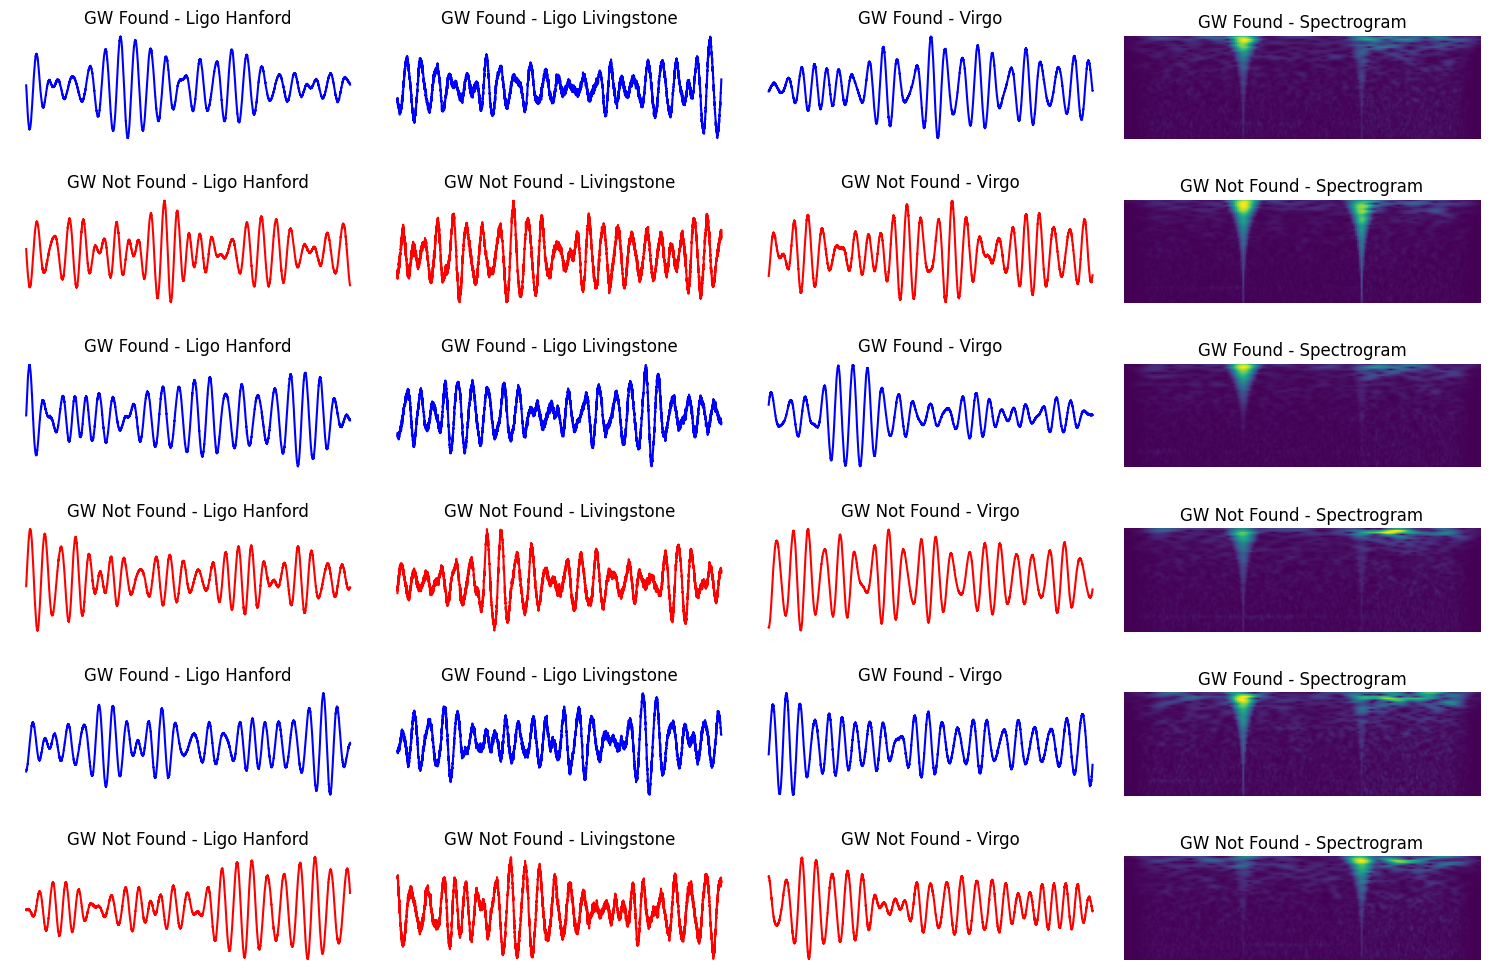

In [ ]:
targets = train_labels[train_labels["target"] == 0]["id"].head(3) #only 3 data files
no_targets = train_labels[train_labels["target"] == 1]["id"].head(3)
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(6, 4, figure=fig)

for i, (target, no_target) in enumerate(zip(targets, no_targets)):
    # Subplot para GW Found (gráfico de líneas)
    ax1 = fig.add_subplot(gs[i*2, 0])
    ax1.plot(np.load(id2path(target))[1, :], color='blue')
    ax1.set_title("GW Found - Ligo Hanford")
    ax1.set_axis_off()

    ax2 = fig.add_subplot(gs[i*2, 1])
    ax2.plot(np.load(id2path(target))[2, :], color='blue')
    ax2.set_title("GW Found - Ligo Livingstone")
    ax2.set_axis_off()

    ax3 = fig.add_subplot(gs[i*2, 2])
    ax3.plot(np.load(id2path(target))[0, :], color='blue')
    ax3.set_title("GW Found - Virgo")
    ax3.set_axis_off()

    ax4 = fig.add_subplot(gs[i*2, 3])
    ax4.imshow(increase_dimension(target, is_train=True))
    ax4.set_title("GW Found - Spectrogram")
    ax4.set_axis_off()


    # Subplot para GW Not Found (gráfico de líneas)
    ax5 = fig.add_subplot(gs[i*2 + 1, 0])
    ax5.plot(np.load(id2path(no_target))[1, :], color='red')
    ax5.set_title("GW Not Found - Ligo Hanford")
    ax5.set_axis_off()

    ax6 = fig.add_subplot(gs[i*2 + 1, 1])
    ax6.plot(np.load(id2path(no_target))[2, :], color='red')
    ax6.set_title("GW Not Found - Livingstone")
    ax6.set_axis_off()

    ax7 = fig.add_subplot(gs[i*2 + 1, 2])
    ax7.plot(np.load(id2path(no_target))[0, :], color='red')
    ax7.set_title("GW Not Found - Virgo")
    ax7.set_axis_off()

    ax8 = fig.add_subplot(gs[i*2 + 1, 3])
    ax8.imshow(increase_dimension(no_target, is_train=True))
    ax8.set_title("GW Not Found - Spectrogram")
    ax8.set_axis_off()

plt.tight_layout()
plt.show()



# Batch Data

In [ ]:
import math
class Dataset(tf.keras.utils.Sequence):
    def __init__(self, data, y = None, batch_size = 256, shuffle = True):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle

        if y is not None:
            self.is_train = True
        else:
            self.is_train = False

        self.y = y

    def __len__(self):
        return math.ceil(len(self.data)/ self.batch_size)

    def __getitem__(self, ids):
        batch_data = self.data[ids * self.batch_size : (ids + 1) * self.batch_size]

        if self.y is not None:
            batch_y = self.y[ids * self.batch_size : (ids + 1) * self.batch_size]

        batch_x = np.array([increase_dimension(x, self.is_train) for x in batch_data])
        print(np.shape(batch_x)[0])
        batch_x = np.stack(batch_x)
        print("After Stack", np.shape(batch_x))

        #if np.shape(batch_x)[0]==self.batch_size:
        if self.is_train:
            return batch_x, batch_y
        else:
            return batch_x

    def on_epoch_end(self):
        if self.shuffle and self.is_train:
            ids_y = list(zip(self.data, self.y))
            shuffle(ids_y)
            self.data, self.y = list(zip(*ids_y))



In [ ]:
train_idx =  train_labels['id'].values
y = train_labels['target'].values
test_idx = sample_submission['id'].values

#x_train,x_valid,y_train,y_valid = train_test_split(train_idx,y,test_size=0.05,random_state=42,stratify=y)
x_train,x_valid,y_train,y_valid = train_test_split(train_idx,y,test_size=0.2,random_state=42,stratify=y)
print(np.shape(x_train))
print(np.shape(x_valid))

#divide data in batches
train_dataset = Dataset(x_train,y_train)
valid_dataset = Dataset(x_valid,y_valid)
test_dataset = Dataset(test_idx)


#print(np.shape(train_dataset))
#print(np.shape(valid_dataset))
#print(np.shape(test_dataset))

def datasetshape(valid_dataset):
    # Assuming `valid_dataset` is a TensorFlow dataset
    # Get a single batch from the dataset
    sample_batch = next(iter(valid_dataset))

    # Access the features and labels from the batch
    features, labels = sample_batch

    # Get the shape of the features
    features_shape = np.shape(features)
    labels_shape = np.shape(labels)

    print("Features shape:", features_shape)
    print("Labels shape:", labels_shape)
    return features,labels


featval,labval=datasetshape(valid_dataset)
feat,lab=datasetshape(train_dataset)

(28128,)
(7032,)
256
After Stack (256, 56, 193, 1)
Features shape: (256, 56, 193, 1)
Labels shape: (256,)
256
After Stack (256, 56, 193, 1)
Features shape: (256, 56, 193, 1)
Labels shape: (256,)


In [ ]:
pip install efficientnet

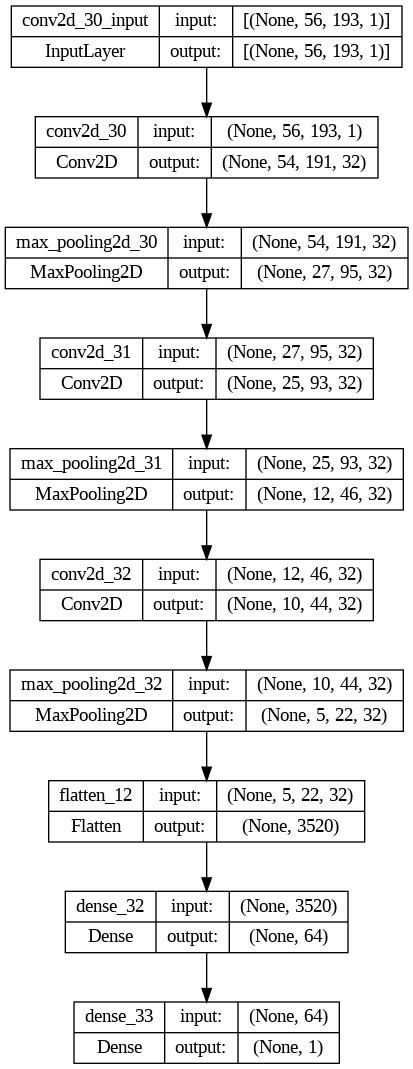

In [ ]:
def create_model():
    Conv1 = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3) ,input_shape = [56, 193, 1], activation = "elu")
    Maxpooling1 = tf.keras.layers.MaxPool2D()
    Conv2 = tf.keras.layers.Conv2D(filters = 32,  kernel_size = (3, 3), activation = "elu")
    Maxpooling2 = tf.keras.layers.MaxPool2D()
    Conv3 = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = "elu")
    Maxpooling3 = tf.keras.layers.MaxPool2D()
    flatten = tf.keras.layers.Flatten()
    Dense1 = tf.keras.layers.Dense(64, activation = "relu")
    dense2 = tf.keras.layers.Dense(1, activation = "sigmoid")

    model = tf.keras.Sequential([Conv1, Maxpooling1,Conv2, Maxpooling2, Conv3, Maxpooling3, flatten ,Dense1, dense2])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

    return model

model = create_model()

from tensorflow.keras.utils import plot_model

# Definir el modelo aquí (igual que en el código anterior)

# Crear un objeto TensorBoard para visualizar el modelo
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')

# Entrenar el modelo con el objeto TensorBoard como argumento de callback
# model.fit(x_train, y_train, epochs=10, callbacks=[tensorboard_callback])

# Generar una imagen del diagrama de flujo del modelo
plot_model(model, to_file='model.png', show_shapes=True)


In [ ]:
# Print a summary of the model architecture
model.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 54, 191, 32)       320       
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 27, 95, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 25, 93, 32)        9248      
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 12, 46, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_32 (Conv2D)          (None, 10, 44, 32)        9248      
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 5, 22, 32)       

In [ ]:
#the history h can be obtained if the test(validation) data split is more than 0.1 of the whole training data.
#To train the CNN use a test split of 0.05 of the whole training data.
h=model.fit(train_dataset, epochs = 2, validation_data = valid_dataset)
import time
start=time.time()
end=time.time()
elapse=end-start
print("time", elapse)

256
After Stack (256, 56, 193, 1)
Epoch 1/2
256
After Stack (256, 56, 193, 1)
256
After Stack (256, 56, 193, 1)
256
After Stack (256, 56, 193, 1)
  3/110 [..............................] - ETA: 7s - loss: 0.6972 - auc: 0.4654256
After Stack (256, 56, 193, 1)
  4/110 [>.............................] - ETA: 2:06 - loss: 0.6967 - auc: 0.4664256
After Stack (256, 56, 193, 1)
  5/110 [>.............................] - ETA: 2:55 - loss: 0.6958 - auc: 0.4814256
After Stack (256, 56, 193, 1)
  6/110 [>.............................] - ETA: 3:02 - loss: 0.6952 - auc: 0.4869256
After Stack (256, 56, 193, 1)
  7/110 [>.............................] - ETA: 2:59 - loss: 0.6947 - auc: 0.4868256
After Stack (256, 56, 193, 1)
  8/110 [=>............................] - ETA: 3:04 - loss: 0.6949 - auc: 0.4827256
After Stack (256, 56, 193, 1)
  9/110 [=>............................] - ETA: 3:04 - loss: 0.6943 - auc: 0.4892256
After Stack (256, 56, 193, 1)
 10/110 [=>............................] - ETA: 3:0

In [ ]:
history=h
preds = model.predict(valid_dataset)
preds = preds.reshape(-1)
#print(np.shape(y_valid))
#print(valid_dataset[0])

import seaborn as sns

sns.histplot(preds)


256
After Stack (256, 56, 193, 1)
256
After Stack (256, 56, 193, 1)
 1/28 [>.............................] - ETA: 2:02256
After Stack (256, 56, 193, 1)
 2/28 [=>............................] - ETA: 1:08256
After Stack (256, 56, 193, 1)
 3/28 [==>...........................] - ETA: 1:01256
After Stack (256, 56, 193, 1)
 4/28 [===>..........................] - ETA: 57s 256
After Stack (256, 56, 193, 1)
 5/28 [====>.........................] - ETA: 53s256
After Stack (256, 56, 193, 1)
 6/28 [=====>........................] - ETA: 53s256
After Stack (256, 56, 193, 1)
 7/28 [======>.......................] - ETA: 55s256
After Stack (256, 56, 193, 1)
 8/28 [=======>......................] - ETA: 51s256
After Stack (256, 56, 193, 1)
 9/28 [========>.....................] - ETA: 48s256
After Stack (256, 56, 193, 1)
10/28 [=========>....................] - ETA: 44s256
After Stack (256, 56, 193, 1)
11/28 [==========>...................] - ETA: 41s256
After Stack (256, 56, 193, 1)
12/28 [========

InvalidArgumentError: ignored

In [ ]:
import seaborn as sns

sns.histplot(preds)
sns.histplot(y_valid)
plt.plot(preds,labval)
plt.show()

NameError: ignored

In [ ]:
# Assuming valid_dataset is an instance of your custom Sequence class

# Get the true labels from the valid_dataset
true_labels = []
for i in range(len(valid_dataset)):
    _, labels = valid_dataset[i]  # Assuming the sequence returns (data, labels) pairs
    true_labels.extend(np.array(labels))  # Convert to NumPy array if labels are tensors

# Convert the predictions to a flat NumPy array
predicted_labels = np.argmax(preds, axis=0)

# Compare the predictions with the true labels
accuracy = np.mean(predicted_labels == true_labels)
print("Accuracy:", accuracy)

256
After Stack (256, 56, 193, 1)
256
After Stack (256, 56, 193, 1)
256
After Stack (256, 56, 193, 1)
256
After Stack (256, 56, 193, 1)
256
After Stack (256, 56, 193, 1)
256
After Stack (256, 56, 193, 1)
256
After Stack (256, 56, 193, 1)
256
After Stack (256, 56, 193, 1)
256
After Stack (256, 56, 193, 1)
256
After Stack (256, 56, 193, 1)
256
After Stack (256, 56, 193, 1)
256
After Stack (256, 56, 193, 1)
256
After Stack (256, 56, 193, 1)
256
After Stack (256, 56, 193, 1)
256
After Stack (256, 56, 193, 1)
256
After Stack (256, 56, 193, 1)
256
After Stack (256, 56, 193, 1)
256
After Stack (256, 56, 193, 1)
256
After Stack (256, 56, 193, 1)
256
After Stack (256, 56, 193, 1)
256
After Stack (256, 56, 193, 1)
256
After Stack (256, 56, 193, 1)
256
After Stack (256, 56, 193, 1)
256
After Stack (256, 56, 193, 1)
256
After Stack (256, 56, 193, 1)
256
After Stack (256, 56, 193, 1)
256
After Stack (256, 56, 193, 1)
120
After Stack (120, 56, 193, 1)


NameError: ignored

In [ ]:
history=h
preds = model.predict(test_dataset)
preds = preds.reshape(-1)
submission = pd.DataFrame({'id':sample_submission['id'],'target':preds})
submission.to_csv('submission.csv',index=False)
submission.head(10)
preds.hist()

FileNotFoundError: ignored

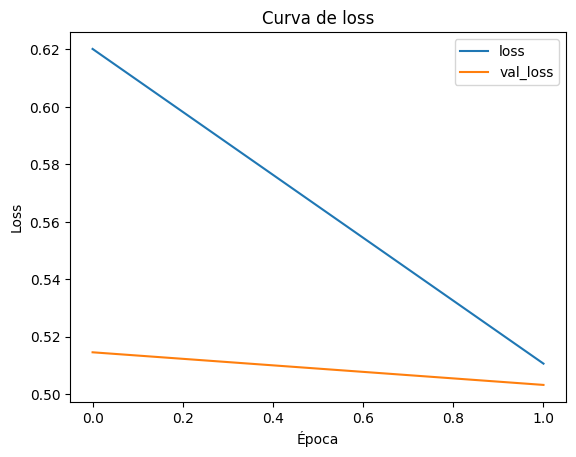

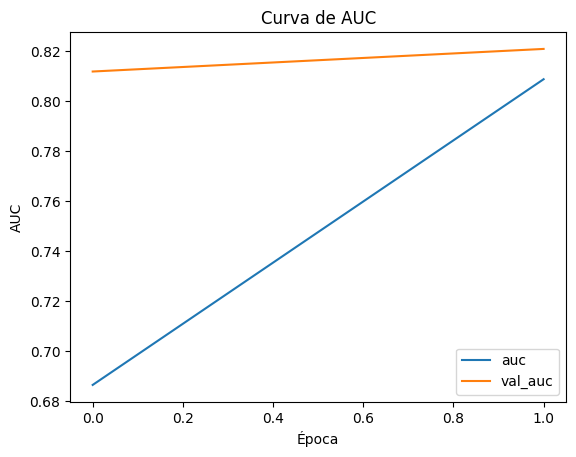

Final Loss: 0.5106552243232727
Final Accuracy: 0.8088838458061218


In [ ]:
# 11. Convergencia del modelo
import matplotlib.pyplot as plt
history=h
# Graficar la curva de loss
plt.plot (history.history ['loss'], label='loss')
plt.plot (history.history ['val_loss'], label='val_loss')
plt.title ('Curva de loss')
plt.xlabel ('Época')
plt.ylabel ('Loss')
plt.legend ()
plt.show ()
# Graficar la curva de accuracy
plt.plot (history.history ['auc'], label='auc')
plt.plot (history.history ['val_auc'], label='val_auc')
plt.title ('Curva de AUC')
plt.xlabel ('Época')
plt.ylabel ('AUC')
plt.legend ()
plt.show ()

#history.history ['score']

"""
# Evaluate the model
#valFeat,ValLabels=valid_dataset
#print(valid_dataset.)
score = model.evaluate(valid_dataset, valid_dataset.y, verbose=0)
print(f'Test loss: {score[0]}')
print(f'Test AUC: {score[1]}')
"""

# Access loss and accuracy values
loss_values = history.history['loss']
accuracy_values = history.history['auc']

# Print the last values (end of training)
final_loss = loss_values[-1]
final_accuracy = accuracy_values[-1]

print(f'Final Loss: {final_loss}')
print(f'Final Accuracy: {final_accuracy}')

# 2.mejorar la CNN de kaggle

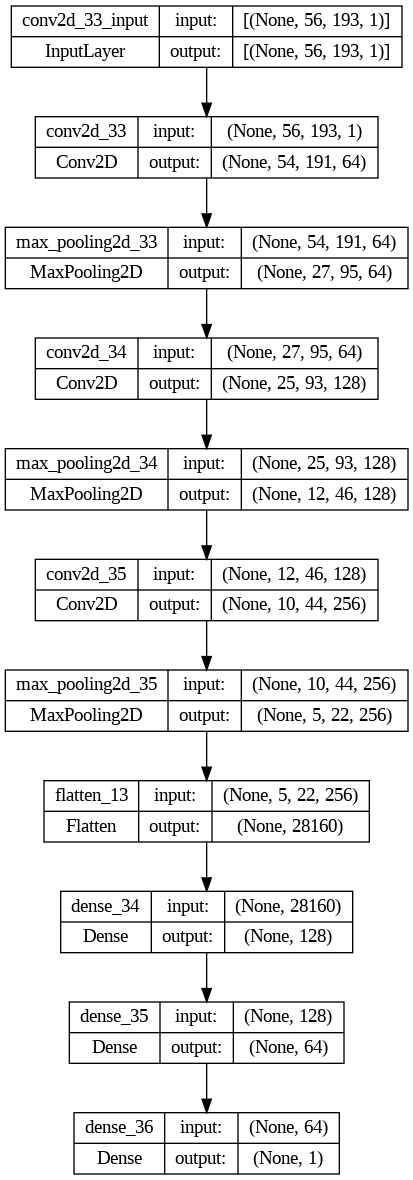

In [ ]:
def create_model():
    Conv1 = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3) ,input_shape = [56, 193, 1], activation = "elu")
    Maxpooling1 = tf.keras.layers.MaxPool2D()
    #BN=tf.keras.layers.BatchNormalization()
    Conv2 = tf.keras.layers.Conv2D(filters = 128,  kernel_size = (3, 3), activation = "elu")
    Maxpooling2 = tf.keras.layers.MaxPool2D()
    #BN2=tf.keras.layers.BatchNormalization()
    Conv3 = tf.keras.layers.Conv2D(filters = 256, kernel_size = (3, 3), activation = "elu")
    Maxpooling3 = tf.keras.layers.MaxPool2D()
    flatten = tf.keras.layers.Flatten()
    #BNd=tf.keras.layers.BatchNormalization()
    d0=tf.keras.layers.Dense(128, activation="relu")
    #Dense1 = tf.keras.layers.Dense(94, activation = "relu")
    Dense1 = tf.keras.layers.Dense(64, activation = "relu")
    #BNd2=tf.keras.layers.BatchNormalization()
    dense2 = tf.keras.layers.Dense(1, activation = "sigmoid")

    model = tf.keras.Sequential([Conv1, Maxpooling1, Conv2, Maxpooling2, Conv3, Maxpooling3, flatten, d0, Dense1, dense2])
    #model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
    #más sensible a los cambios de dirección del gradiente y evite oscilaciones innecesarias
    model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

    return model

model = create_model()

from tensorflow.keras.utils import plot_model

# Definir el modelo aquí (igual que en el código anterior)

# Crear un objeto TensorBoard para visualizar el modelo
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')

# Entrenar el modelo con el objeto TensorBoard como argumento de callback
# model.fit(x_train, y_train, epochs=10, callbacks=[tensorboard_callback])

# Generar una imagen del diagrama de flujo del modelo
plot_model(model, to_file='model.png', show_shapes=True)


In [ ]:
# Print a summary of the model architecture
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 54, 191, 64)       640       
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 27, 95, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_34 (Conv2D)          (None, 25, 93, 128)       73856     
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 12, 46, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_35 (Conv2D)          (None, 10, 44, 256)       295168    
                                                                 
 max_pooling2d_35 (MaxPooli  (None, 5, 22, 256)      

In [ ]:
#the history h can be obtained if the test(validation) data split is more than 0.1 of the whole training data.
#To train the CNN use a test split of 0.05 of the whole training data.
historyy=model.fit(train_dataset, epochs = 2, validation_data = valid_dataset)
import time
start=time.time()
end=time.time()
elapse=end-start
print("time", elapse)

256
After Stack (256, 56, 193, 1)
Epoch 1/2
256
After Stack (256, 56, 193, 1)
256
After Stack (256, 56, 193, 1)
  2/110 [..............................] - ETA: 23s - loss: 0.6923 - auc_7: 0.5231  256
After Stack (256, 56, 193, 1)
  3/110 [..............................] - ETA: 58s - loss: 0.6918 - auc_7: 0.5244256
After Stack (256, 56, 193, 1)
  4/110 [>.............................] - ETA: 1:44 - loss: 0.6903 - auc_7: 0.5371256
After Stack (256, 56, 193, 1)
  5/110 [>.............................] - ETA: 2:10 - loss: 0.6909 - auc_7: 0.5351256
After Stack (256, 56, 193, 1)
  6/110 [>.............................] - ETA: 2:20 - loss: 0.6922 - auc_7: 0.5304256
After Stack (256, 56, 193, 1)
  7/110 [>.............................] - ETA: 2:27 - loss: 0.6916 - auc_7: 0.5351256
After Stack (256, 56, 193, 1)
  8/110 [=>............................] - ETA: 2:38 - loss: 0.6915 - auc_7: 0.5349256
After Stack (256, 56, 193, 1)
  9/110 [=>............................] - ETA: 2:57 - loss: 0.6925 -

In [ ]:
history=h
preds = model.predict(valid_dataset)
preds = preds.reshape(-1)
#print(preds)
#print(valid_dataset[0])


In [ ]:
history=h
preds = model.predict(test_dataset)
preds = preds.reshape(-1)
submission = pd.DataFrame({'id':sample_submission['id'],'target':preds})
submission.to_csv('submission.csv',index=False)
submission.head(10)

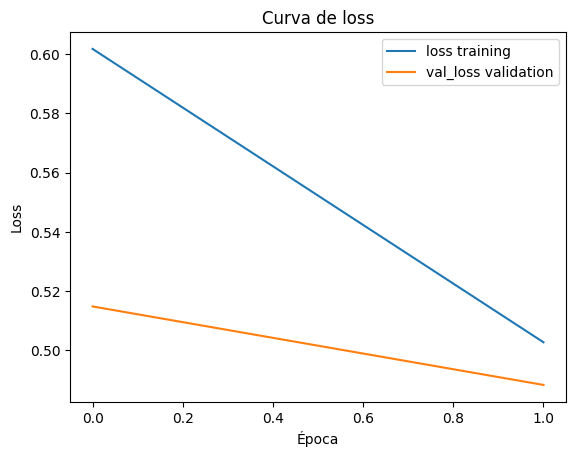

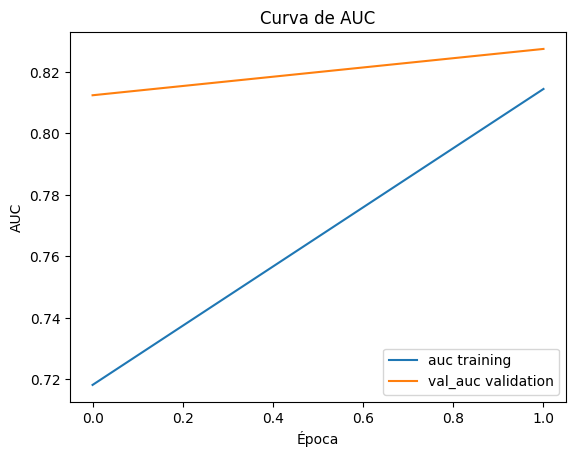

Final Loss: 0.5027613043785095
Final Accuracy: 0.8144722580909729


In [ ]:
# 11. Convergencia del modelo
import matplotlib.pyplot as plt
# Graficar la curva de loss
plt.plot (history.history ['loss'], label='loss training')
plt.plot (history.history ['val_loss'], label='val_loss validation')
plt.title ('Curva de loss')
plt.xlabel ('Época')
plt.ylabel ('Loss')
plt.legend ()
plt.show ()
# Graficar la curva de accuracy
plt.plot (history.history ['auc_2'], label='auc training')
plt.plot (history.history ['val_auc_2'], label='val_auc validation')
plt.title ('Curva de AUC')
plt.xlabel ('Época')
plt.ylabel ('AUC')
plt.legend ()
plt.show ()

#history.history ['score']

"""
# Evaluate the model
#valFeat,ValLabels=valid_dataset
#print(valid_dataset.)
score = model.evaluate(valid_dataset, valid_dataset.y, verbose=0)
print(f'Test loss: {score[0]}')
print(f'Test AUC: {score[1]}')
"""

# Access loss and accuracy values
loss_values = history.history['loss']
accuracy_values = history.history['auc_2']

# Print the last values (end of training)
final_loss = loss_values[-1]
final_accuracy = accuracy_values[-1]

print(f'Final Loss: {final_loss}')
print(f'Final Accuracy: {final_accuracy}')

#mejora leve al utilizar un numero mayor de filtros
0.809 con 32 filtros (split 0.1)\
0.814 con 64 filtros y un poco menos de data (split con 0.2 para val)

#**VGG** for time series CNN

#Qiu et al. Article's CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, Activation

#X_train = X_train.reshape(60000,28,28,1)
#X_test = X_test.reshape(10000,28,28,1)
#inputshape = (16384,1)
inputshape = (28128,1)

def ConvolutionalBlock(model,inputshape,FiltNum,firstlayer):

    # Assuming you have input data with shape (sequence_length, input_dim)
    # For example, if your data is a time series with 1 feature per time step:

    # Add a 1D convolutional layer with 32 filters, kernel size of 3, and 'relu' activation
    if (firstlayer=="firstlayer"):
      model.add(Conv1D(FiltNum, kernel_size=16, input_shape=inputshape)) #(sequence_length, input_dim)))
    else:
      model.add(Conv1D(FiltNum, kernel_size=16))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    # Add a max pooling layer to down-sample the output of the convolutional layer
    #model.add(MaxPooling1D(pool_size=2))

    # Flatten the output to connect to a dense layer
    #model.add(Flatten())

    model.add(Conv1D(FiltNum, kernel_size=8))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv1D(FiltNum, kernel_size=8))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling1D(pool_size=4, strides=4))

model = Sequential()
ConvolutionalBlock(model,inputshape,32,"firstlayer")
#aqui hay que agregar un input shape diferente, o quitarlo
ConvolutionalBlock(model,inputshape,64,2)
ConvolutionalBlock(model,inputshape,128,3)
ConvolutionalBlock(model,inputshape,256,4)

model.add(Flatten())

### Neural Networks ###
# Add a dense layer for classification (or any other output layer as needed)
model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Dense(64))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Output layer
#model.add(Dense(units=num_classes, activation='softmax'))
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 28113, 32)         544       
                                                                 
 activation_14 (Activation)  (None, 28113, 32)         0         
                                                                 
 batch_normalization_18 (Ba  (None, 28113, 32)         128       
 tchNormalization)                                               
                                                                 
 conv1d_13 (Conv1D)          (None, 28106, 32)         8224      
                                                                 
 activation_15 (Activation)  (None, 28106, 32)         0         
                                                                 
 batch_normalization_19 (Ba  (None, 28106, 32)         128       
 tchNormalization)                                    

In [ ]:
print(np.shape(x_train))
h1d=model.fit(x_train,y_train, epochs = 2)

(28128,)
Epoch 1/2


ValueError: ignored